# Topic Modeling Tuned
### Muf Tayebaly

In [24]:
#imports
import pandas as pd
import numpy as np
import pickle as pk
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import string
import re
from random import randint
from collections import defaultdict
from gensim import matutils, models, utils
import scipy.sparse
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim import corpora
import tqdm
from gensim.utils import simple_preprocess

In [15]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/Muf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Muf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/Muf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Muf/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
#load data from pickle
corpus_data = pd.read_pickle('Data/muf_articles_corpus.pkl')
data_raw = pd.read_csv('Data/knight_data_articles.csv')
corpus_data.shape

(1914, 32)

In [3]:
corpus_data.head()
data_raw.head()

,content_id,content_body_clean,content_title_clean,label,economy,topic2,science,mention_Trump,mention_Clinton,mention_Democrat,...,mention_terrorist,mention_attack,mention_NRA,mention_sanctuary,mention_socialist,mention_fascist,mention_communist,mention_nationalist,mention_2A,content_source_desc
0,60,Republicans in Congress are at a make or break...,Tax reform now -- failure to act could mean mi...,9,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
1,61,The Constitution authorizes Congress to tax Am...,Tax reform -- America needs a tax code that's ...,9,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
2,66,"A long-mothballed, unfinished casino-hotel on ...",Long-mothballed Las Vegas Strip casino-hotel s...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
3,80,If taxing foreign earnings that have already a...,"Trump Tax Plan May Free Up Corporate Dollars, ...",3,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,The New York Times
4,82,Hurricane Harvey has already taken an enormous...,Hurricane Harvey is a humanitarian disaster. I...,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vox


### Stopwords List

In [69]:
#add some common words to the stopwords that we do not want
new_stopwords = stopwords.words('english') + ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 
                                              'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 
                                              'year', 'group', 'people']                       

## Title & Body - Bigrams - Nouns Only

In [79]:
#clean data
def clean_data(text):
    #remove punctuation, digits, extra stuff. make lowercase
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    #lemma it - include POS tag in order to lemma it better
    tag_map = defaultdict(lambda : wordnet.NOUN)
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV
    lemmatizer = WordNetLemmatizer()
    textTokens = word_tokenize(text)
    #remove stopwords
    word_tokens_nostop = [w for w in textTokens if not w in new_stopwords] 
    #now lemma
    text = [lemmatizer.lemmatize(tok, tag_map[tag[0]]) for tok, tag in pos_tag(word_tokens_nostop)]
    return " ".join(text)

def nouns(text):
    #get nouns only
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

def nouns_adjs(text):
    #get nouns only
    is_noun = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

def make_bigrams(data_words_list):
    bigram = models.Phrases(data_words_list, min_count=8, threshold=100)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in data_words_list]

def make_bigrams_trigrams(data_words_list):
    bigram = models.Phrases(data_words_list, min_count=8, threshold=100)
    bigram_mod = models.phrases.Phraser(bigram)
    trigram = models.Phrases(bigram[data_words_list], threshold=100)
    trigram_mod = models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in data_words_list]

### Clean Data & Concatenate Title and Body

In [71]:
cdata = data_raw
cdata["content_body_clean"] = cdata["content_body_clean"].apply(clean_data)
cdata["content_title_clean"] = cdata["content_title_clean"].apply(clean_data)

In [73]:
concat_data = pd.DataFrame(columns=['content_id','content_full_clean'])
for i in range(0,len(cdata)):
    full_content = cdata['content_title_clean'].iloc[i] + " " + cdata['content_body_clean'].iloc[i]
    concat_data = concat_data.append({'content_id':cdata['content_id'].iloc[i],
                                     'content_full_clean':full_content}, ignore_index=True)

In [74]:
concat_data.head()

,content_id,content_full_clean
0,60,tax reform failure act could mean minority sta...
1,61,tax reform america need tax code good country ...
2,66,longmothballed la vega strip casinohotel sell ...
3,80,trump tax plan may free corporate dollar tax f...
4,82,hurricane harvey humanitarian disaster also se...


### Make Bigrams

In [75]:
concat_data_words = list(sent_to_words(concat_data['content_full_clean']))

In [77]:
data_bigrams = make_bigrams(concat_data_words)

In [78]:
data_bigrams[0]

['tax_reform', 'failure', 'act', 'could', 'mean', 'minority', 'status', 'gop', 'republican', 'congress', 'make', 'break', 'moment', 'everyone', 'moments', 'come', 'around', 'often', 'politics', 'president', 'donald', 'trump', 'speaker', 'house', 'paul_ryan', 'senate', 'majority_leader', 'mitch_mcconnell', 'agree', 'come', 'seize', 'real', 'lasting', 'tax_reform', 'lead', 'job_creation', 'fuel', 'economic', 'engine', 'future', 'generation', 'republican', 'well', 'trumpstate', 'democrat', 'seek', 'help', 'hardworking', 'american', 'taxpayer', 'progrowth', 'legislation', 'need', 'come', 'together', 'must', 'get', 'robust', 'tax_reform', 'bill', 'sign', 'law', 'american', 'republican', 'control', 'white_house', 'house', 'congress', 'look', 'first', 'six', 'month', 'congress', 'little', 'show', 'congress', 'doesnt', 'act', 'appear', 'campaign', 'rhetoric', 'talk', 'president', 'united_state', 'ask', 'congress', 'send', 'tax_reform', 'package', 'desk', 'obama_administration', 'republican', '

### Nouns & Adjs only

In [80]:
new_texts = pd.DataFrame(columns=['content_full_bigrams'])
for data in data_bigrams:
    addData = ' '.join(data)
    new_texts = new_texts.append({'content_full_bigrams':addData}, ignore_index=True)

In [81]:
data_nouns = pd.DataFrame(new_texts["content_full_bigrams"].apply(nouns_adjs))

In [82]:
new_data_words = list(sent_to_words(data_nouns['content_full_bigrams']))
len(new_data_words)

1914

### Model

In [83]:
# Create Dictionary
id2word = corpora.Dictionary(new_data_words)
# Create Corpus
texts = new_data_words
# Term Document Frequency
tdm = [id2word.doc2bow(text) for text in texts]

In [84]:
from tqdm import tqdm

model = []
c_s = []
nt = []
np = []

n_topics = range(6,16,1)
n_passes = [10,25,50,75,100]

for t in tqdm(n_topics):
    for p in n_passes:
        this_model = models.LdaMulticore(corpus=tdm, id2word=id2word, num_topics=t, random_state=101,
                                chunksize=140, passes=p, per_word_topics=True)
        tcoherence_model_lda = CoherenceModel(model=this_model, texts=texts, dictionary=id2word, coherence='c_v')
        tcoherence_lda = tcoherence_model_lda.get_coherence()
        
        model.append(this_model)
        c_s.append(tcoherence_lda)
        nt.append(t)
        np.append(p)
print("done")

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:14:46<00:00, 448.68s/it]


done


In [85]:
multi_model = {'num_topics':nt, 'num_passes':np, 'model':model, 'coherence_score':c_s}
multi_model_df = pd.DataFrame(multi_model)

In [86]:
multi_model_df.to_pickle('topic_model_multi_bigrams.pkl')

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

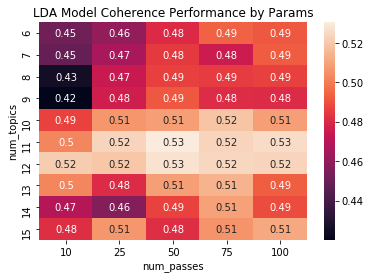

In [88]:
res = pd.pivot_table(pd.DataFrame(multi_model_df),
    values='coherence_score', index='num_topics', columns='num_passes')
ax = plt.axes()
ax.set_title("LDA Model Coherence Performance by Params")
sns.heatmap(res, annot=True)
plt.show()

In [124]:
multi_model_df[(multi_model_df["num_topics"]==11) & (multi_model_df["num_passes"]==50)]

,num_topics,num_passes,model,coherence_score
27,11,50,"LdaModel(num_terms=28832, num_topics=11, decay...",0.53031


In [125]:
pprint(multi_model_df['model'].iloc[27].print_topics())

[(0,
  '0.033*"tax" + 0.012*"plan" + 0.010*"percent" + 0.009*"bill" + 0.009*"trump" '
  '+ 0.009*"american" + 0.009*"cut" + 0.007*"rate" + 0.006*"state" + '
  '0.006*"policy"'),
 (1,
  '0.012*"apple" + 0.012*"new" + 0.008*"use" + 0.007*"iphone" + 0.006*"amazon" '
  '+ 0.006*"company" + 0.005*"police" + 0.005*"technology" + 0.005*"computer" '
  '+ 0.005*"device"'),
 (2,
  '0.041*"percent" + 0.013*"job" + 0.010*"company" + 0.010*"economy" + '
  '0.010*"price" + 0.009*"market" + 0.008*"rise" + 0.007*"month" + '
  '0.007*"bank" + 0.007*"high"'),
 (3,
  '0.023*"trump" + 0.012*"president" + 0.007*"call" + 0.005*"american" + '
  '0.005*"day" + 0.004*"family" + 0.004*"political" + 0.004*"attack" + '
  '0.004*"claim" + 0.004*"talk"'),
 (4,
  '0.030*"republican" + 0.023*"trump" + 0.013*"senate" + 0.013*"state" + '
  '0.012*"president" + 0.012*"democrat" + 0.010*"party" + 0.010*"house" + '
  '0.009*"election" + 0.009*"vote"'),
 (5,
  '0.017*"company" + 0.014*"uber" + 0.011*"google" + 0.009*"techn

In [116]:
topic_list = ['Policy','Technology','Economy','Politics','Politics','Technology',
              'Public Health','Politics','Public Health','Scandal','Scandal']

In [117]:
topics = pd.DataFrame(columns=['content_id','content_body_clean','content_title_clean','topic','topic_id1',
                               'topic_p1','topic_id2','topic_p2','topic_dist'])

for r in range(0,len(data_raw)):
    this_doc = id2word.doc2bow(texts[r])
    topicID = sorted(multi_model_df['model'].iloc[27].get_document_topics(this_doc), key=lambda x: x[1], reverse=True)
    if len(topicID) > 1:
        topicID2 = topicID[1]
    else:
        topicID2 = ["",""]
    
    topics = topics.append({'content_id': data_raw['content_id'].iloc[r], 
                            'content_body_clean':data_raw['content_body_clean'].iloc[r],
                            'content_title_clean':data_raw['content_title_clean'].iloc[r], 
                            'topic':topic_list[topicID[0][0]],
                            'topic_id1':topicID[0][0],
                            'topic_p1':topicID[0][1], 
                            'topic_id2':topicID2[0],
                            'topic_p2':topicID2[1],
                            'topic_dist':multi_model_df['model'].iloc[27].get_document_topics(this_doc) }, ignore_index=True)

In [126]:
topics

,content_id,content_body_clean,content_title_clean,topic,topic_id1,topic_p1,topic_id2,topic_p2,topic_dist
0,60,republican congress make break moment everyone...,tax reform failure act could mean minority sta...,Policy,0,0.548654,4,0.398622,"[(0, 0.54865676), (1, 0.035524607), (2, 0.0146..."
1,61,constitution authorize congress tax american p...,tax reform america need tax code good country ...,Policy,0,0.832200,3,0.0988222,"[(0, 0.83220094), (3, 0.098824225), (4, 0.0664..."
2,66,longmothballed unfinished casinohotel la vega ...,longmothballed la vega strip casinohotel sell,Economy,2,0.677059,3,0.14728,"[(1, 0.09982404), (2, 0.6770535), (3, 0.147273..."
3,80,tax foreign earnings already accumulate overse...,trump tax plan may free corporate dollar,Policy,0,0.994644,,,"[(0, 0.9946441)]"
4,82,hurricane harvey already take enormous human t...,hurricane harvey humanitarian disaster also se...,Public Health,6,0.759787,2,0.237297,"[(2, 0.23729898), (6, 0.7597849)]"
...,...,...,...,...,...,...,...,...,...
1909,3380,oct file photo venezuela president nicolas mad...,investor leave venezuela meeting clear insight,Politics,7,0.746023,1,0.0920419,"[(0, 0.04390687), (1, 0.09204196), (2, 0.07198..."
1910,3381,man watch stock price board brokerage house be...,global stock turn low recent record high,Economy,2,0.979205,7,0.0174803,"[(2, 0.97920525), (7, 0.017479869)]"
1911,3382,drain massive aquifer underlies portion eight ...,rural area risk water level drop massive aquifer,Public Health,6,0.983829,2,0.0113818,"[(2, 0.011387455), (6, 0.983823)]"
1912,3383,orbital atks antares rocket lift wallop island...,frozen treat supply rocket toward space station,Technology,5,0.419648,7,0.284927,"[(2, 0.022637565), (4, 0.01546725), (5, 0.4196..."


In [121]:
topics.to_csv("Data/article_topics_6.csv")